<a href="https://colab.research.google.com/github/huimarco/spotify-rating-prediction/blob/main/spotify_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview

Spotify one of the largest music streaming service providers, with over 422 million monthly active users, including 182 million paying subscribers, as of March 2022. Many share their experience with the application in the form of a written review and a rating score on its Google Play Store page.


---


This project looks to use user written reviews to predict given app rating score.


---


Through this project, I hope to practice/gain exposure to:
* basic natural language processing techniques
* basic sentiment analysis
* data wrangling in python
* machine learning models in python (random forest, XGBoost, etc.)
* clear written documentation

## Preparation

Import libaries to the notebook (make sure that all are installed beforehand)

In [77]:
# wrangle data
import numpy as np
import pandas as pd

# import files
from google.colab import files
import io

# natural language processing
import emoji
import nltk

# visualise data
import seaborn as sns

# model
from sklearn.model_selection import train_test_split

Upload csv files from local desktop

In [ ]:
uploaded = files.upload()

Read csv files into pandas dataframes

In [113]:
data = pd.read_csv(io.StringIO(uploaded['reviews.csv'].decode('utf-8')))

## Exploratory Data Analysis

Get a general overview of data, including the name, number of non-null values, and data type of each column

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


See summary statistics of numerical columns

In [32]:
data.describe()

,Rating,Total_thumbsup,wordCount
count,61594.000000,61594.000000,61594.000000
mean,3.155989,7.649381,30.886418
std,1.673285,89.323143,22.743734
min,1.000000,0.000000,2.000000
25%,1.000000,0.000000,14.000000
50%,3.000000,0.000000,25.000000
75%,5.000000,1.000000,42.000000
max,5.000000,8195.000000,699.000000


Visualise distribution of ratings

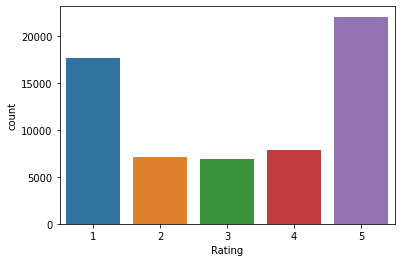

In [33]:
sns.countplot(x='Rating', data=data)

## Data Wrangling

In [116]:
data.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


Drop unecessary columns

In [122]:
data.drop(['Time_submitted','Total_thumbsup','Reply'],axis=1,inplace=True)

Remove numbers from reviews

In [125]:
data['Review'] = data['Review'].str.replace('\d', '', regex=True)

Make reviews lower case

In [35]:
data['Review'] = data['Review'].str.lower()

## Feature Engineering

Features used for modelling

| name | description |
| --- | --- |
|emojiCount|number of emojis used in review|
|wordCount|number of words used in review|
|adj|number of adjectives used in review|





Create emojiCount

In [85]:
data['emojiCount'] = data['Review'].apply(lambda x : emoji.emoji_count(x))
# remove emojis from review once counted
data['Review'] = data['Review'].apply(lambda x : emoji.replace_emoji(x, replace=''))

Create wordCount

In [18]:
data['wordCount'] = data['Review'].str.count(' ') + 1

Create parts of speech

In [39]:
review = 'this is Mony app no install this app, wink is best and gana is best app😒😒'
review = review.lower()

# tokenize words
tokens = nltk.word_tokenize(review)

# assign parts of speech (pos) to each word
tagged = nltk.pos_tag(tokens)

In [40]:
tagged

[('this', 'DT'),
 ('is', 'VBZ'),
 ('mony', 'JJ'),
 ('app', 'IN'),
 ('no', 'DT'),
 ('install', 'NN'),
 ('this', 'DT'),
 ('app', 'NN'),
 (',', ','),
 ('wink', 'NN'),
 ('is', 'VBZ'),
 ('best', 'RBS'),
 ('and', 'CC'),
 ('gana', 'NN'),
 ('is', 'VBZ'),
 ('best', 'RBS'),
 ('app😒😒', 'NN')]